In [3]:
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import glob
import numpy as np
import os, glob
import csv
import operator
from matplotlib import rcParams



def buildDataFrame(filePath, colNames, dropCols, numericCols, quant):
    df_temp = pd.read_csv(filePath,names=colNames)
    for colName in dropCols:
        df_temp = df_temp.drop(colName, 1)
    df_temp = df_temp[numericCols].apply(pd.to_numeric,errors='coerce')
    df_temp = df_temp.sort_values(by='start_ts', ascending=[True])
    if quant != 0:
        df_temp = df_temp[df_temp.start_ts > df_temp.start_ts.quantile(quant)]
    return df_temp

#['geo','latency','mx','mn','wc','start_ts']
def pruneForDenseWindows(dataframe,percentage):
    pd.to_numeric(dataframe.wc)
    topWindows = dataframe.wc.quantile(percentage)
    #print(topWindows)
    dataframe = dataframe[dataframe.wc > topWindows  ]
    return dataframe


def pandasDraw(listOfFilePaths,_figsize,_range, colNames, dropCols, numericCols, quant, isLatency):
    for fileGroup in listOfFilePaths:
        df_list = []
        for file in fileGroup:
            column_name = file.rsplit('.', 1)[0]
            temp_df = buildDataFrame(file, colNames, dropCols, numericCols, quant)
            if(isLatency):
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.latency},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
            else:
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.its},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
        df_final = pd.concat(df_list)
        ax_df_final = df_final.hist(figsize=_figsize,bins=100,range=_range)
    plt.show()
    


def dataGeneratorStats(path,_figsize):
    d = {}
    fileCount = 0
    for filePath in glob.glob(path + '*'):
        fileCount = fileCount + 1
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) , 1
            k = int(k)
            if k in d:
                d[k]  = tuple(map(operator.add, d[k], v))
            else:
                d[k] = v
    finalD = {}
    for k, v in d.items():
        if v[1] == fileCount:
            finalD[k] = v[0]
    df = pd.DataFrame(list(finalD.items()),columns=['ts', 'count'])
    df = df.sort_values(by='ts', ascending=[True])
    df.plot.bar(y='count', x = 'ts',figsize=_figsize,)
    plt.show()

def dataGeneratorStatsSeparate(path,_figsize,_xlabel,_ylabel,_xticks):
    df_list = []
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] , 'count': [int(i[1]) for i in d.items()]},columns=['ts', 'count'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df_list.append(df)
        ax=df.plot(y='count', x = 'ts',figsize=_figsize, xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks) ,marker='x')
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)

    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    plt.show()

def dataGeneratorStatsSeparateOneAxis(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] },columns=['ts'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df['count'] = list(range(1, len(df) + 1))


        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

    
def dataGeneratorStatsSeparateOneAxis2(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        df = pd.read_csv(filePath,names=['ts','count'])
        df['count'] = df['count']/1000000;
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl

        

        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

def latencyTimeSeries(df,_figsize,_xticks,out_path,_ylim_ts,_yticks_ts):
    # df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))



    # plt.show()
    #matplotlib.rcParams['agg.path.chunksize'] = 1000
    plt.rcParams['agg.path.chunksize'] = 10000
    df = df.sort_values(by='start_ts', ascending=[True])
    minEl = df.start_ts.iloc[0]
    df['start_ts'] = df['start_ts'] - minEl
    df['start_ts'] = df['start_ts'] /1000
    df['start_ts'] = df['start_ts'] * 2
    fig, ax = plt.subplots()
    df.plot.line(rasterized=True,legend=False,
                 ylim=_ylim_ts,
                 y='latency', 
                 x = 'start_ts',
                 figsize=_figsize,
                 xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), _xticks),
                 yticks = np.arange(0,  _ylim_ts[1], _yticks_ts), 


                 ax=ax)
    ax.set(xlabel="Timestamp", ylabel="Latency (ms)")


    plt.setp( ax.get_xticklabels(), visible=True)
    fig.savefig(out_path + '_ts.eps', format='eps', dpi=1000)

    plt.show()

    print('average latency is:')
    print(df.latency.mean())
    print('min latency is:')
    print(df.latency.min())
    print('max latency is:')
    print(df.latency.max())
    print('quantiles:')
    print(df.latency.quantile(0.9) )
    print( df.latency.quantile(0.95))
    print( df.latency.quantile(0.99))



def drawAggregationFigures(in_path,out_path,_range,_figsize, _bins, _xticks,_ylim_hist, _ylim_ts,_yticks_ts):
    temp_df = buildDataFrame(in_path,
               ['latency','start_ts'],
               [],
               ['latency','start_ts'],
              0.25)
    df = pd.DataFrame({'latency':temp_df.latency,  'start_ts':temp_df.start_ts},
                      columns=['latency','start_ts'])
    frames = [df, df]
    dfs = pd.concat(frames)
    rcParams.update({'figure.autolayout': True})
    fig, ax = plt.subplots()
    ax_df_final = dfs.latency.plot.hist(ylim=_ylim_hist,figsize=_figsize,bins=_bins,range=_range,ax=ax)
    ax.set(xlabel="Latency (ms)", ylabel="Count")
    
    latencyTimeSeries(df,_figsize,_xticks,out_path,_ylim_ts,_yticks_ts)
    fig.savefig(out_path+'_hist.eps', format='eps', dpi=1000)


    plt.show()











/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


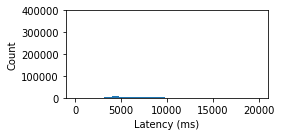

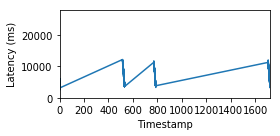

average latency is:
6162.76993454
min latency is:
2523
max latency is:
12200
quantiles:
9075.0
9903.549999999996
10985.0


In [8]:
drawAggregationFigures('../results/spark_join_temp.csv','../paper/images/eps/spark_join_temp'
                       ,[0,20000],(4,2),100,200,(0,400000), (0,28000))




### Spark 16x, 2 node, 8-4 window th_max

Parameters:
- 365K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 28 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 800ms



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


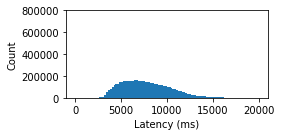

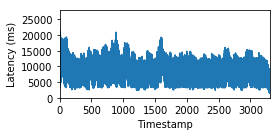

average latency is:
7724.16197109
min latency is:
1376
max latency is:
21600
quantiles:
11297.0
12409.0
14718.0


In [6]:
drawAggregationFigures('../results/spark_join_2node_th_max.csv','../paper/images/eps/spark_join_2node_th_max'
                       ,[0,20000],(4,2),100,500,(0,800000), (0,28000),5000)



### Spark 16x, 2 node, 8-4 window th_90

Parameters:
- 328K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 24 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 500ms




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


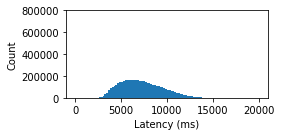

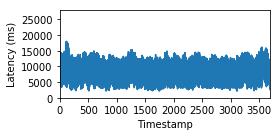

average latency is:
7195.97121758
min latency is:
2157
max latency is:
17981
quantiles:
10316.0
11178.0
12702.0


In [7]:
drawAggregationFigures('../results/spark_join_2node_th_90.csv','../paper/images/eps/spark_join_2node_th_90'
                       ,[0,20000],(4,2),100,500,(0,800000), (0,28000),5000)


### Spark 16x, 4 node, 8-4 window th_max

Parameters:
- 632K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 49 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 800ms




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


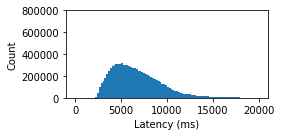

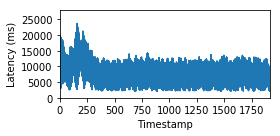

average latency is:
6730.10584185
min latency is:
2139
max latency is:
23647
quantiles:
10279.0
11788.0
15410.0


In [9]:
drawAggregationFigures('../results/spark_join_4node_th_max.csv','../paper/images/eps/spark_join_4node_th_max'
                       ,[0,20000],(4,2),100,250,(0,800000), (0,28000),5000)


### Spark 16x, 4 node, 8-4 window th_90

Parameters:
- 570K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 44 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 400ms




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


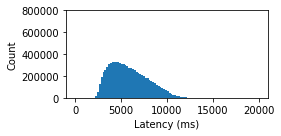

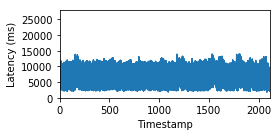

average latency is:
5834.26785702
min latency is:
1861
max latency is:
13956
quantiles:
8741.0
9525.0
10729.0


In [11]:
drawAggregationFigures('../results/spark_join_4node_th_90.csv','../paper/images/eps/spark_join_4node_th_90'
                       ,[0,20000],(4,2),100,500,(0,800000), (0,28000),5000)


### Spark 16x, 8 node, 8-4 window th_max

Parameters:
- 947K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 78 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 500ms



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


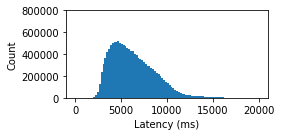

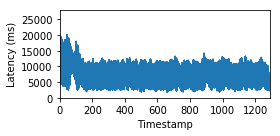

average latency is:
6263.46524384
min latency is:
1841
max latency is:
19993
quantiles:
9465.0
10469.0
13242.0


In [12]:
drawAggregationFigures('../results/spark_join_8node_th_max.csv','../paper/images/eps/spark_join_8node_th_max'
                       ,[0,20000],(4,2),100,200,(0,800000), (0,28000),5000)


### Spark 16x, 8 node, 8-4 window th_90

Parameters:
- 836K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 68 tuples generated,( 0.5 , 1000 selectivity, 1000 price range) 
- 4000 batch, 400ms




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


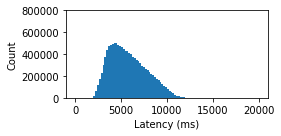

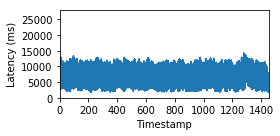

average latency is:
5788.88532729
min latency is:
1721
max latency is:
14197
quantiles:
8678.0
9454.0
10625.0


In [13]:
drawAggregationFigures('../results/spark_join_8node_th_90.csv','../paper/images/eps/spark_join_8node_th_90'
                       ,[0,20000],(4,2),100,200,(0,800000), (0,28000),5000)

